- Data analysis - [https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python](https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python)  
- Image conversion, Network architecture - https://www.kaggle.com/tivigovidiu/keras-model-for-beginners-0-210-on-lb-eda-r-d => 404  
- Some ideas - [https://www.kaggle.com/knowledgegrappler/a-keras-prototype-0-21174-on-pl](https://www.kaggle.com/knowledgegrappler/a-keras-prototype-0-21174-on-pl)  
- Code for conversion to image provided by MadScientist but i don't know which kernel it is.



In [2]:
# Random initialization
import numpy as np
np.random.seed(98643)
import tensorflow as tf
tf.compat.v1.set_random_seed(683)

In [3]:
# An image clearing dependencies
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma, denoise_tv_bregman, denoise_nl_means)
from skimage.filters import gaussian
from skimage.color import rgb2gray

In [4]:
# Data reading and visualization
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

In [5]:
# Training part
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, GlobalAveragePooling2D, Lambda
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

떼이터 전처리가 필요  
이미지의 경우 noise를 제거해야 한다, (granular noise를 제거)  
It is also interesting to train a denoising autoencoder on dataset in order to extract some global features that may be used further on model training.

In [6]:
# Translate data to an image format
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        # flatten한걸 75, 75의 형태로 reshape
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2
        
        # 각 데이터들에서 rgb성분들만 따로 뽑아서,,?
        # 그러기에는 base_1은 red이고, 2는 green, 3은 Blue인가?
        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))

        # np.dstack 같은 사이즈의 행렬이 3개 쌓이면 여기같은 경우는 (75, 75) x 3
        # rgb는 (75, 75, 3)의 shape로 들어가게된다.
        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

# denoise => skimage에서 import
def denoise(X, weight, multichannel):
    return np.asarray([denoise_tv_chambolle(item, weight=weight, multichannel=multichannel) for item in X])

def smooth(X, sigma):
    return np.asarray([gaussian(item, sigma=sigma) for item in X])

def grayscale(X):
    return np.asarray([rgb2gray(item) for item in X])

In [7]:
train = pd.read_json("../data/processed/train.json")
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
train_all = True

# These are train flags that required to train model more efficiently and 
# select proper model parameters
train_b = True or train_all
train_img = True or train_all
train_total = True or train_all
predict_submission = True and train_all

clean_all = False
clean_b = False or clean_all
clean_img = False or clean_all

load_all = False
load_b = False or load_all
load_img = False or load_all

In [8]:
# 데이터셋 생성
def create_dataset(frame, labeled, smooth_rgb=0.2, smooth_gray=0.5,
                   weight_rgb=0.05, weight_gray=0.05):
    
    band_1, band_2, images = frame['band_1'].values, frame['band_2'].values, color_composite(frame)
    # np.arr로 변환
    to_arr = lambda x: np.asarray([np.asarray(item) for item in x])
    band_1 = to_arr(band_1)
    band_2 = to_arr(band_2)
    band_3 = (band_1 + band_2) / 2
    
    gray_reshape = lambda x: np.asarray([item.reshape(75, 75) for item in x])
    # Make a picture format from flat vector => resize
    band_1 = gray_reshape(band_1)
    band_2 = gray_reshape(band_2)
    band_3 = gray_reshape(band_3)
    print('Denoising and reshaping')
    
    
    if train_b and clean_b:
        # Smooth and denoise data
        band_1 = smooth(denoise(band_1, weight_gray, False), smooth_gray)
        print('Gray 1 done')
        band_2 = smooth(denoise(band_2, weight_gray, False), smooth_gray)
        print('Gray 2 done')
        band_3 = smooth(denoise(band_3, weight_gray, False), smooth_gray)
        print('Gray 3 done')
    if train_img and clean_img:
        images = smooth(denoise(images, weight_rgb, True), smooth_rgb)
    print('RGB done')
    
    
    tf_reshape = lambda x: np.asarray([item.reshape(75, 75, 1) for item in x])
    band_1 = tf_reshape(band_1)
    band_2 = tf_reshape(band_2)
    band_3 = tf_reshape(band_3)
    #images = tf_reshape(images)
    # axis=3????
    band = np.concatenate([band_1, band_2, band_3], axis=3)
    if labeled:
        y = np.array(frame["is_iceberg"])
    else:
        y = None
    return y, band, images

In [9]:
y_train, X_b, X_images = create_dataset(train, True)

Denoising and reshaping
RGB done


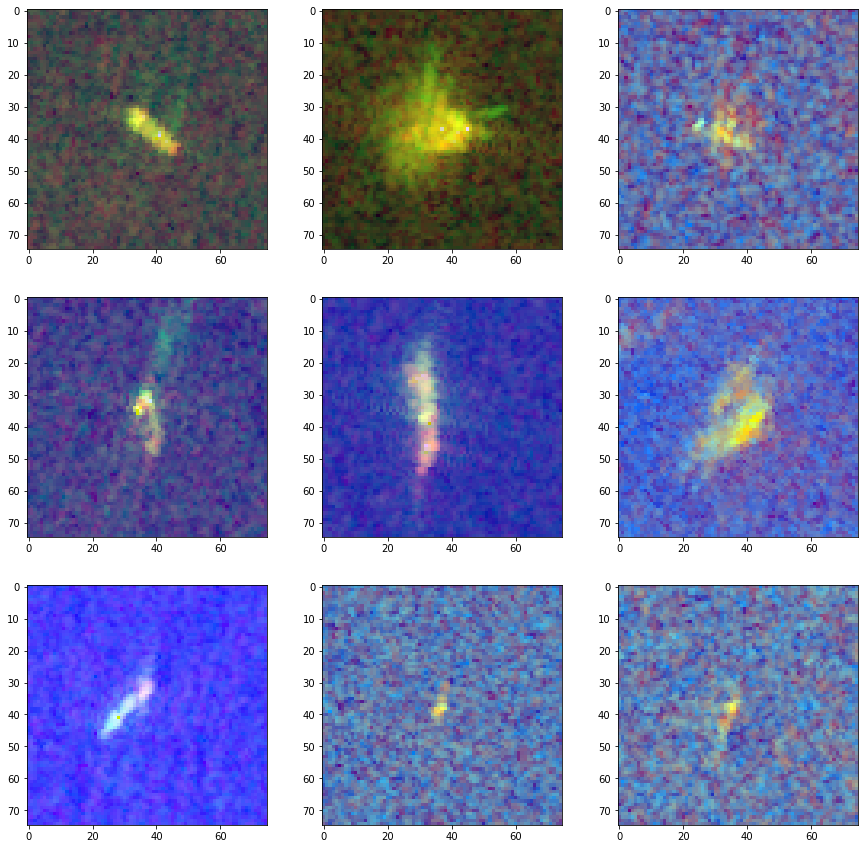

In [10]:
# 위에서 전처리한 X_images를 사용

fig = plt.figure(200, figsize=(15, 15))
random_indicies = np.random.choice(range(len(X_images)), 9, False)
subset = X_images[random_indicies]
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

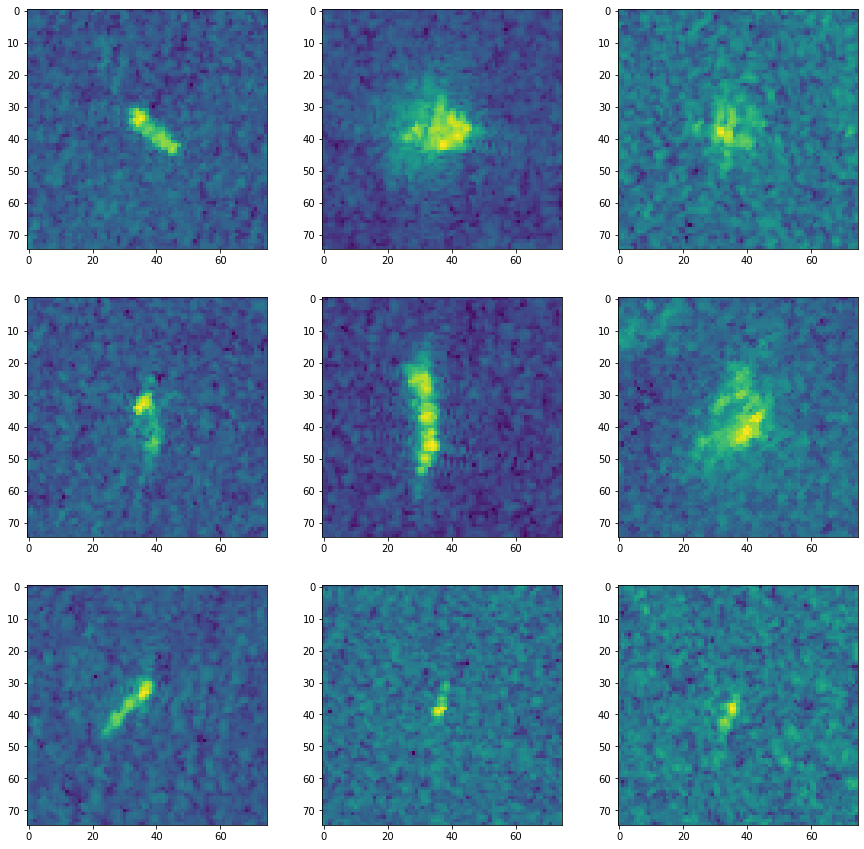

In [11]:
# train['band_1'] => 단순히 reshape
# 아무런 전처리가 없는것

fig = plt.figure(202, figsize=(15, 15))
band_1_x = train['band_1'].values
subset = np.asarray(band_1_x)[random_indicies]
subset = np.asarray([np.asarray(item).reshape(75, 75) for item in subset])
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

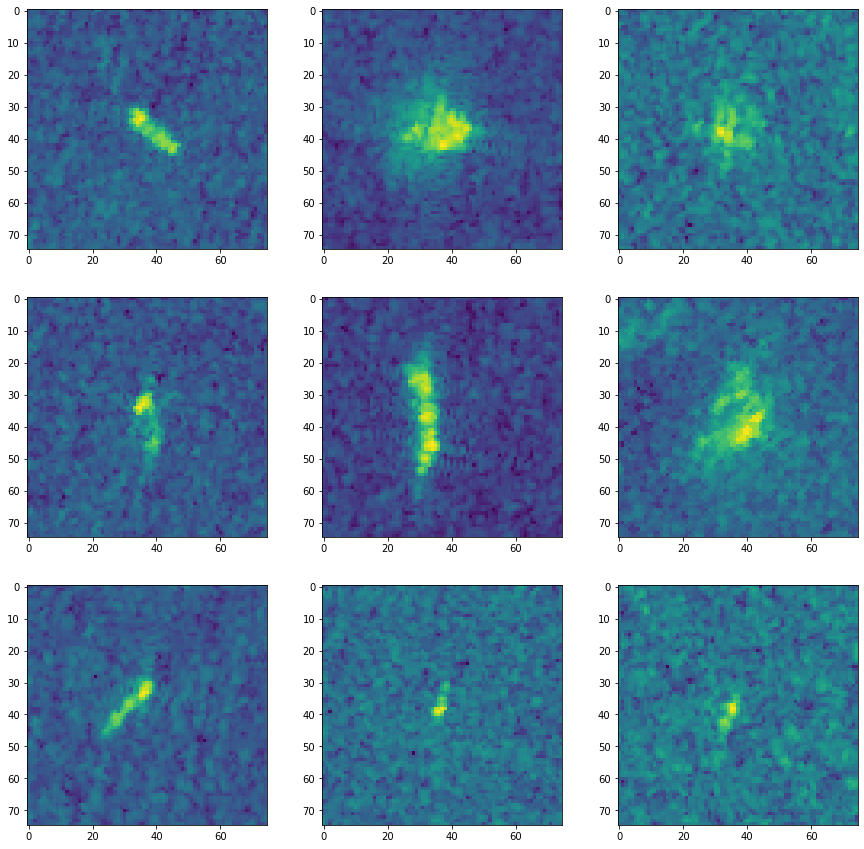

In [12]:
# denoise

fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indicies]
subset = denoise(np.asarray([np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

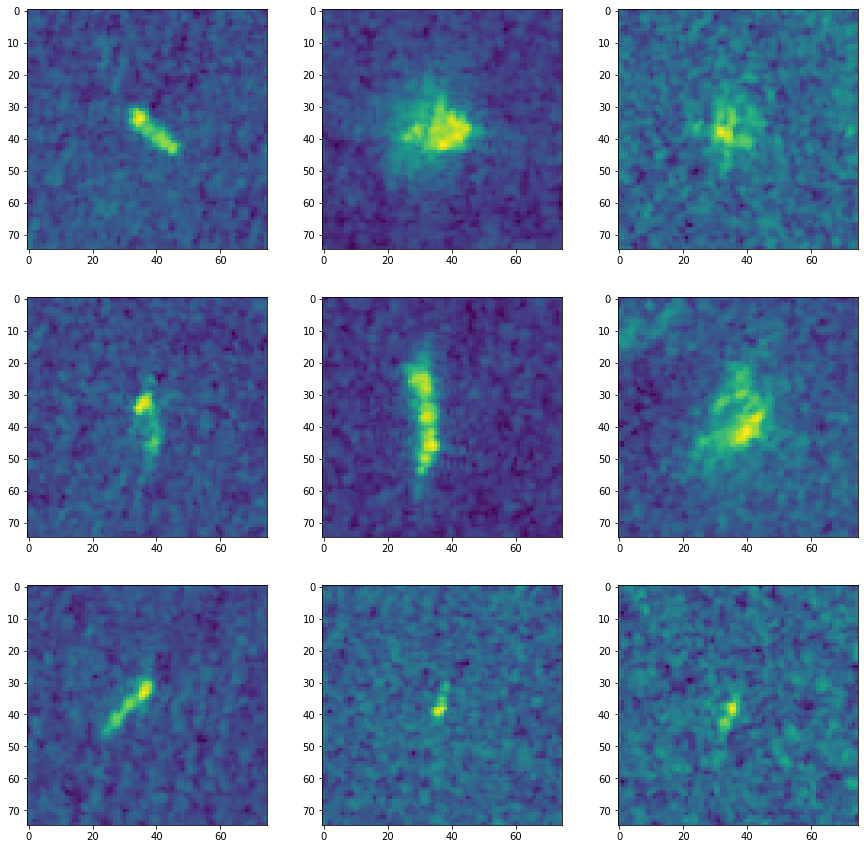

In [13]:
# smooth

fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indicies]
subset = smooth(denoise(np.asarray(
    [np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False), 0.5)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

- 3개의 CNN으로 구성
    - 2개의 basic, 1개의 Combine (combined?)
    - 2개의 basic한 네트워크로 다른 데이터들을 학습, 그 후에 학습된 conv 층을 사용한다..? (The idea is to train two basic networks on different data representations and after that, using trained convolutional layers in combination to train common network.)
    
- Architecture for these networks is taken from notebook mentioned in the vere beginning.

- For training i'm using 3 datasets, 1 that network sees only once and default keras val split for model selection

In [14]:
def get_model_notebook(lr, decay, channels, relu_type='relu'):
    # angle variable defines if we should use angle parameter or ignore it
    
    input_1 = Input(shape=(75, 75, channels))

    fcnn = Conv2D(32, kernel_size=(3, 3), activation=relu_type)(
        BatchNormalization()(input_1))
    fcnn = MaxPooling2D((3, 3))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    
    fcnn = Conv2D(64, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = BatchNormalization()(fcnn)
    
    fcnn = Flatten()(fcnn)
    
    # input층을 저장
    local_input = input_1
    
    # dense층이 없고 Flatten까지한 부분 모델을 partial_model에 저장
    partial_model = Model(input_1, fcnn)
    
    dense = Dropout(0.2)(fcnn)
    dense = Dense(256, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(128, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(64, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    
    # For some reason i've decided not to normalize angle data
    output = Dense(1, activation="sigmoid")(dense)
    
    # dense까지 포함된 model
    model = Model(local_input, output)
    optimizer = Adam(lr=lr, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model, partial_model

In [15]:
def combined_model(m_b, m_img, lr, decay):
    # input층
    input_b = Input(shape=(75, 75, 3))
    input_img = Input(shape=(75, 75, 3))

    # I've never tested non-trainable source models tho
    #for layer in m_b.layers:
    #    layer.trainable = False
    #for layer in m_img.layers:
    #    layer.trainable = False

    m1 = m_b(input_b)
    m2 = m_img(input_img)
    
    # layers에 Concatenate() 가 있는 듯 하다 이전에도 나오던데
    # So, combine models and train perceptron based on that
    # The iteresting idea is to use XGB for this task, but i actually hate this method
    common = Concatenate()([m1, m2])
    common = BatchNormalization()(common)
    common = Dropout(0.3)(common)
    
    common = Dense(1024, activation='relu')(common)
    common = Dropout(0.3)(common)
    
    common = Dense(512, activation='relu')(common)
    common = Dropout(0.3)(common)
    
    output = Dense(1, activation="sigmoid")(common)
    
    model = Model([input_b, input_img], output)
    optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [16]:
# augmentation
def gen_flow_multi_inputs(I1, I2, y, batch_size):
    gen1 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    gen2 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    genI1 = gen1.flow(I1, y, batch_size=batch_size, seed=57, shuffle=False)
    genI2 = gen2.flow(I1, I2, batch_size=batch_size, seed=57, shuffle=False)
    while True:
        I1i = genI1.next()
        I2i = genI2.next()
        #print I1i[0].shape
        np.testing.assert_array_equal(I2i[0], I1i[0])
        yield [I1i[0], I2i[1]], I1i[1]

In [41]:
def train_model(model, batch_size, epochs, checkpoint_name, X_train, y_train, val_data, verbose=2):
    
    callbacks = [ModelCheckpoint(checkpoint_name, save_best_only=True, monitor='val_loss')]
    
    datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.,
                                   height_shift_range=0.,
                                   channel_shift_range=0,
                                   zoom_range=0.2,
                                   rotation_range=10)
    # 그냥 넣어도 되지 않나?
    x_test, y_test = val_data
    
    try:
        model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs,
                                    steps_per_epoch=len(X_train) / batch_size,
                                    validation_data=(x_test, y_test), verbose=1,
                                    callbacks=callbacks)
    except KeyboardInterrupt:
        if verbose > 0:
            print('Interrupted')
    if verbose > 0:
        print('Loading model')
    # 이부분에서 에러
    print(checkpoint_name)
    checkpoint_name ="zaaaa.hdf5"
    model.load_weights(filepath=checkpoint_name)
    return model

In [42]:
#Train a particular model
def gen_model_weights(lr, decay, channels, relu, batch_size, epochs, path_name, data, verbose=2):
    X_train, y_train, X_test, y_test, X_val, y_val = data
    model, partial_model = get_model_notebook(lr, decay, channels, relu)
    model = train_model(model, batch_size, epochs, path_name,
                           X_train, y_train, (X_test, y_test), verbose=verbose)

    if verbose > 0:
        loss_val, acc_val = model.evaluate(X_val, y_val,
                               verbose=0, batch_size=batch_size)

        loss_train, acc_train = model.evaluate(X_test, y_test,
                                       verbose=0, batch_size=batch_size)

        print('Val/Train Loss:', str(loss_val) + '/' + str(loss_train), \
            'Val/Train Acc:', str(acc_val) + '/' + str(acc_train))
    return model, partial_model

In [43]:
# Train all 3 models
def train_models(dataset, lr, batch_size, max_epoch, verbose=2, return_model=False):
    y_train, X_b, X_images = dataset
    
    y_train_full, y_val,\
    X_b_full, X_b_val,\
    X_images_full, X_images_val = train_test_split(y_train, X_b, X_images, random_state=687, train_size=0.9)

    y_train, y_test, \
    X_b_train, X_b_test, \
    X_images_train, X_images_test = train_test_split(y_train_full, X_b_full, X_images_full, random_state=576, train_size=0.85)

    if train_b:
        if verbose > 0:
            print('Training bandwidth network')
        data_b1 = (X_b_train, y_train, X_b_test, y_test, X_b_val, y_val)
        model_b, model_b_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_b',
                                                 data=data_b1, verbose=verbose)

    if train_img:
        if verbose > 0:
            print('Training image network')
        data_images = (X_images_train, y_train, X_images_test, y_test, X_images_val, y_val)
        model_images, model_images_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_img',
                                                       data_images, verbose=verbose)

    if train_total:
        common_model = combined_model(model_b_cut, model_images_cut, lr/2, 1e-7)
        common_x_train = [X_b_full, X_images_full]
        common_y_train = y_train_full
        common_x_val = [X_b_val, X_images_val]
        common_y_val = y_val
        if verbose > 0:
            print('Training common network')
        callbacks = [ModelCheckpoint('common', save_best_only=True, monitor='val_loss')]
        try:
            common_model.fit_generator(gen_flow_multi_inputs(X_b_full, X_images_full, y_train_full, batch_size),
                                         epochs=30,
                                  steps_per_epoch=len(X_b_full) / batch_size,
                                  validation_data=(common_x_val, common_y_val), verbose=1,
                                  callbacks=callbacks)
        except KeyboardInterrupt:
            pass
        common_model.load_weights(filepath='common')
        loss_val, acc_val = common_model.evaluate(common_x_val, common_y_val,
                                           verbose=0, batch_size=batch_size)
        loss_train, acc_train = common_model.evaluate(common_x_train, common_y_train,
                                                  verbose=0, batch_size=batch_size)
        if verbose > 0:
            print('Loss:', loss_val, 'Acc:', acc_val)
    if return_model:
        return common_model
    else:
        return (loss_train, acc_train), (loss_val, acc_val)

In [44]:
# Best parameters i got are
# epochs : 250
# learning rate : 8e-5
# batch size : 32
common_model = train_models((y_train, X_b, X_images), 7e-04, 32, 50, 1, return_model=True)

Training bandwidth network
Epoch 1/50
39/38 [==============================] - 2s 59ms/step - loss: 0.6484 - accuracy: 0.6011 - val_loss: 1.9827 - val_accuracy: 0.5253
Epoch 2/50
39/38 [==============================] - 2s 58ms/step - loss: 0.6184 - accuracy: 0.6305 - val_loss: 1.9706 - val_accuracy: 0.5253
Epoch 3/50
39/38 [==============================] - 2s 59ms/step - loss: 0.5870 - accuracy: 0.6680 - val_loss: 1.0019 - val_accuracy: 0.5253
Epoch 4/50
39/38 [==============================] - 3s 70ms/step - loss: 0.5369 - accuracy: 0.6990 - val_loss: 0.5357 - val_accuracy: 0.7051
Epoch 5/50
39/38 [==============================] - 2s 57ms/step - loss: 0.5176 - accuracy: 0.7406 - val_loss: 0.5218 - val_accuracy: 0.7189
Epoch 6/50
39/38 [==============================] - 1s 24ms/step - loss: 0.4886 - accuracy: 0.7594 - val_loss: 0.5387 - val_accuracy: 0.7005
Epoch 7/50
39/38 [==============================] - 2s 57ms/step - loss: 0.4697 - accuracy: 0.7765 - val_loss: 0.5121 - val_acc

OSError: Unable to open file (file read failed: time = Wed Aug 26 01:09:23 2020
, filename = 'model_b', file descriptor = 76, errno = 21, error message = 'Is a directory', buf = 0x7ffd7e529540, total read size = 8, bytes this sub-read = 8, bytes actually read = 18446744073709551615, offset = 0)

한번 학습을 마치고 모델을 저장후에 불러오는 부분에서 에러가 난다.
hdf5형태로 저장이 안되서, 파일이 없어서 불러올 수 없다는 건가?
checkpoint_name => 'model_b'  
하지만 에러메세지에서는 디렉토리이기 때문에 읽어올 수 없다고 한다.  
모델은 계속해서 ```saved_model.pb``` 형식으로 계속 최고의 성능이 나올 경우에 저장이 되고 있지만...
![image](https://user-images.githubusercontent.com/48716219/91199306-ae7f8900-e738-11ea-8d21-74a0f82b9bc5.png)

---

- 에러메세지
    1. OSError => ```error message = "is a directory"```
        ```model_b```는 디렉토리가 맞음..
    2. 에러메세지 위에는 다음과 같은 부분이 있다
        ![image](https://user-images.githubusercontent.com/48716219/91199520-f43c5180-e738-11ea-9c4e-e1e91d154a8c.png)
        hdf5형식의 파일을 찾을 수 없다는 것인가?
- 그러면 checkpoint를 만들때 h5로 저장을 시킨 후 불러오는 건가..?
    - 여기서 Checkpoint를 사용해서 저장하는 모델은 ```pb```인것 같은데..

In [ ]:
if predict_submission:
    print('Reading test dataset')
    test = pd.read_json("../input/test.json")
    y_fin, X_fin_b, X_fin_img = create_dataset(test, False)
    print('Predicting')
    prediction = common_model.predict([X_fin_b, X_fin_img], verbose=1, batch_size=32)
    print('Submitting')
    submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})

    submission.to_csv("./submission.csv", index=False)
    print('Done')